# Warsztaty badawcze - Projekt 2

## Real Estate Price Analysis - XGBoost

### Wiktoria Boguszewska, Mateusz Zacharecki, Patrycja Żak

In [2]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 66.7 MB/s eta 0:00:00


In [5]:
!pip install scikit-optimize

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from skopt import BayesSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Categorical, Integer
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import mean_squared_error
import random

from transformers import BertTokenizer, BertModel
import torch

import warnings
warnings.filterwarnings('ignore')

random.seed(42)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-11-06 21:17:46.769568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has alr

### Wczytanie danych

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("real_estate_not_imputed.csv")
df.head()

,district_lon,district_lat,no_rooms,m,price_per_m,map_lon,map_lat,building_floors_num,created_at_first_ts,created_at_ts,media_types_phone,media_types_cable-television,media_types_internet,equipment_types_fridge,equipment_types_stove,equipment_types_washing_machine,equipment_types_oven,equipment_types_dishwasher,equipment_types_furniture,equipment_types_tv,extras_types_basement,extras_types_balcony,extras_types_terrace,extras_types_garden,extras_types_two_storey,extras_types_garage,extras_types_air_conditioning,extras_types_usable_room,extras_types_separate_kitchen,extras_types_lift,security_types_alarm,security_types_roller_shutters,security_types_monitoring,security_types_closed_area,security_types_anti_burglary_door,security_types_entryphone,building_material_breezeblock,building_material_brick,building_material_cellular_concrete,building_material_concrete,building_material_concrete_plate,building_material_hydroton,building_material_other,building_material_reinforced_concrete,building_material_silikat,windows_type_aluminium,windows_type_plastic,windows_type_wooden,heating_boiler_room,heating_electrical,heating_gas,heating_other,heating_tiled_stove,heating_urban,construction_status_ready_to_use,construction_status_to_completion,construction_status_to_renovation,building_ownership_co_operative_ownership,building_ownership_co_operative_ownership_with_a_land_and_mortgage_registe,building_ownership_full_ownership,building_ownership_share,building_type_apartment,building_type_block,building_type_house,building_type_ribbon,building_type_tenement,title,description,building_type,floor_no,building_material,windows_type,heating,build_year,construction_status,rent,building_ownership,free_from,media_types,security_types,equipment_types,extras_types,remote_services,floor_no_numeric,free_from_year,created_at_first,created_at
0,16.9408,52.38356,3.0,48.000000,6020.83,16.959516,52.391494,4.0,1.515071e+09,1.515411e+09,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,NaN,<p>Zapraszam do zapoznania się z ofertą sprzed...,block,floor_1,NaN,plastic,urban,NaN,NaN,NaN,co_operative_ownership_with_a_land_and_mortgag...,NaN,"['cable-television', 'internet', 'phone']",[''],[''],"['balcony', 'separate_kitchen']",NaN,1.0,NaN,2018-01-04 13:11:05,2018-01-08 11:27:35
1,16.9408,52.38356,3.0,61.000000,6213.11,16.950743,52.380535,4.0,1.516044e+09,1.516879e+09,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,NaN,<p>Zapraszam do zapoznania się z ofertą sprzed...,block,ground_floor,NaN,wooden,urban,NaN,ready_to_use,550.0,co_operative_ownership_with_a_land_and_mortgag...,NaN,"['cable-television', 'internet']",[''],[''],['balcony'],NaN,0.0,NaN,2018-01-15 19:12:07,2018-01-25 11:11:31
2,16.9408,52.38356,3.0,63.000000,5380.95,16.945860,52.393188,4.0,1.515074e+09,1.515650e+09,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,Rataje Nowe Miasto Niski Blok,<p>Weychan Nieruchomości Monika Hałas - Kurcza...,block,floor_3,concrete_plate,NaN,NaN,NaN,NaN,NaN,co_operative_ownership,NaN,[''],['entryphone'],[''],"['balcony', 'basement']",NaN,3.0,NaN,2018-01-04 13:53:29,2018-01-11 05:55:12
3,16.9408,52.38356,3.0,59.200001,5574.32,16.980279,52.391129,4.0,1.515755e+09,1.517323e+09,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,"Mieszkanie 3 pokojowe blisko tramwaju, Poznań os.",<p>Oferuję na sprzedaż jasne i zadbane mieszka...,block,floor_1,concrete_plate,wooden,urban,1980.0,ready_to_use,NaN,co_operative_ownership,NaN,[''],['entryphone'],[''],"['balcony', 'basement']",NaN,1.0,NaN,2018-01-12 11:10:57,2018-01-30 14:38:39
4,16.9408,52.38356,2.0,38.000000,6815.79,16.950027,52.395861,10.0,1.514893e+09,1.516285e+09,1,1,1,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,"Inwestycja -ro

### Feature selection and standarization

In [4]:
df.shape

(5953, 87)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5953 entries, 0 to 5952
Data columns (total 87 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   district_lon                                                                5889 non-null   float64
 1   district_lat                                                                5889 non-null   float64
 2   no_rooms                                                                    5952 non-null   float64
 3   m                                                                           5953 non-null   float64
 4   price_per_m                                                                 5953 non-null   float64
 5   map_lon                                                                     5953 non-null   float64
 6   map_lat                                         

In [6]:
pd.set_option('display.max_columns', None)

Do modelu bazowego usuwamy kolumny, które nie będziemy używać, tj. opis, długość i szerokość geograficzna

In [7]:
df.drop(['title', 'description', 'map_lon', 'map_lat'], axis=1, inplace=True)
# Zostawiamy wstępnie daty i szerokość, długość geo. dzielnic

In [8]:
df.head()

,district_lon,district_lat,no_rooms,m,price_per_m,building_floors_num,created_at_first_ts,created_at_ts,media_types_phone,media_types_cable-television,media_types_internet,equipment_types_fridge,equipment_types_stove,equipment_types_washing_machine,equipment_types_oven,equipment_types_dishwasher,equipment_types_furniture,equipment_types_tv,extras_types_basement,extras_types_balcony,extras_types_terrace,extras_types_garden,extras_types_two_storey,extras_types_garage,extras_types_air_conditioning,extras_types_usable_room,extras_types_separate_kitchen,extras_types_lift,security_types_alarm,security_types_roller_shutters,security_types_monitoring,security_types_closed_area,security_types_anti_burglary_door,security_types_entryphone,building_material_breezeblock,building_material_brick,building_material_cellular_concrete,building_material_concrete,building_material_concrete_plate,building_material_hydroton,building_material_other,building_material_reinforced_concrete,building_material_silikat,windows_type_aluminium,windows_type_plastic,windows_type_wooden,heating_boiler_room,heating_electrical,heating_gas,heating_other,heating_tiled_stove,heating_urban,construction_status_ready_to_use,construction_status_to_completion,construction_status_to_renovation,building_ownership_co_operative_ownership,building_ownership_co_operative_ownership_with_a_land_and_mortgage_registe,building_ownership_full_ownership,building_ownership_share,building_type_apartment,building_type_block,building_type_house,building_type_ribbon,building_type_tenement,building_type,floor_no,building_material,windows_type,heating,build_year,construction_status,rent,building_ownership,free_from,media_types,security_types,equipment_types,extras_types,remote_services,floor_no_numeric,free_from_year,created_at_first,created_at
0,16.9408,52.38356,3.0,48.000000,6020.83,4.0,1.515071e+09,1.515411e+09,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,block,floor_1,NaN,plastic,urban,NaN,NaN,NaN,co_operative_ownership_with_a_land_and_mortgag...,NaN,"['cable-television', 'internet', 'phone']",[''],[''],"['balcony', 'separate_kitchen']",NaN,1.0,NaN,2018-01-04 13:11:05,2018-01-08 11:27:35
1,16.9408,52.38356,3.0,61.000000,6213.11,4.0,1.516044e+09,1.516879e+09,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,block,ground_floor,NaN,wooden,urban,NaN,ready_to_use,550.0,co_operative_ownership_with_a_land_and_mortgag...,NaN,"['cable-television', 'internet']",[''],[''],['balcony'],NaN,0.0,NaN,2018-01-15 19:12:07,2018-01-25 11:11:31
2,16.9408,52.38356,3.0,63.000000,5380.95,4.0,1.515074e+09,1.515650e+09,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,block,floor_3,concrete_plate,NaN,NaN,NaN,NaN,NaN,co_operative_ownership,NaN,[''],['entryphone'],[''],"['balcony', 'basement']",NaN,3.0,NaN,2018-01-04 13:53:29,2018-01-11 05:55:12
3,16.9408,52.38356,3.0,59.200001,5574.32,4.0,1.515755e+09,1.517323e+09,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,block,floor_1,concrete_plate,wooden,urban,1980.0,ready_to_use,NaN,co_operative_ownership,NaN,[''],['entryphone'],[''],"['balcony', 'basement']",NaN,1.0,NaN,2018-01-12 11:10:57,2018-01-30 14:38:39
4,16.9408,52.38356,2.0,38.000000,6815.79,10.0,1.514893e+09,1.516285e+09,1,1,1,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,block,floor_1,concrete_plate,plastic,urban,1980.0,ready_to_use,NaN,co_operative_ownership_with_a_land_and_mortgag...,NaN,"['cable-television', 'internet', 'phone']",['entryphone'],"['fridge', 'furniture', 'stove', 'washing_mach...",['basement'],NaN,1.0,NaN,2018-01-02 11:34:51,2018-01-18 14:22:29


In [9]:
df.drop(['created_at_first', 'created_at'], axis=1, inplace=True)

In [10]:
df.head()

,district_lon,district_lat,no_rooms,m,price_per_m,building_floors_num,created_at_first_ts,created_at_ts,media_types_phone,media_types_cable-television,media_types_internet,equipment_types_fridge,equipment_types_stove,equipment_types_washing_machine,equipment_types_oven,equipment_types_dishwasher,equipment_types_furniture,equipment_types_tv,extras_types_basement,extras_types_balcony,extras_types_terrace,extras_types_garden,extras_types_two_storey,extras_types_garage,extras_types_air_conditioning,extras_types_usable_room,extras_types_separate_kitchen,extras_types_lift,security_types_alarm,security_types_roller_shutters,security_types_monitoring,security_types_closed_area,security_types_anti_burglary_door,security_types_entryphone,building_material_breezeblock,building_material_brick,building_material_cellular_concrete,building_material_concrete,building_material_concrete_plate,building_material_hydroton,building_material_other,building_material_reinforced_concrete,building_material_silikat,windows_type_aluminium,windows_type_plastic,windows_type_wooden,heating_boiler_room,heating_electrical,heating_gas,heating_other,heating_tiled_stove,heating_urban,construction_status_ready_to_use,construction_status_to_completion,construction_status_to_renovation,building_ownership_co_operative_ownership,building_ownership_co_operative_ownership_with_a_land_and_mortgage_registe,building_ownership_full_ownership,building_ownership_share,building_type_apartment,building_type_block,building_type_house,building_type_ribbon,building_type_tenement,building_type,floor_no,building_material,windows_type,heating,build_year,construction_status,rent,building_ownership,free_from,media_types,security_types,equipment_types,extras_types,remote_services,floor_no_numeric,free_from_year
0,16.9408,52.38356,3.0,48.000000,6020.83,4.0,1.515071e+09,1.515411e+09,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,block,floor_1,NaN,plastic,urban,NaN,NaN,NaN,co_operative_ownership_with_a_land_and_mortgag...,NaN,"['cable-television', 'internet', 'phone']",[''],[''],"['balcony', 'separate_kitchen']",NaN,1.0,NaN
1,16.9408,52.38356,3.0,61.000000,6213.11,4.0,1.516044e+09,1.516879e+09,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,block,ground_floor,NaN,wooden,urban,NaN,ready_to_use,550.0,co_operative_ownership_with_a_land_and_mortgag...,NaN,"['cable-television', 'internet']",[''],[''],['balcony'],NaN,0.0,NaN
2,16.9408,52.38356,3.0,63.000000,5380.95,4.0,1.515074e+09,1.515650e+09,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,block,floor_3,concrete_plate,NaN,NaN,NaN,NaN,NaN,co_operative_ownership,NaN,[''],['entryphone'],[''],"['balcony', 'basement']",NaN,3.0,NaN
3,16.9408,52.38356,3.0,59.200001,5574.32,4.0,1.515755e+09,1.517323e+09,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,block,floor_1,concrete_plate,wooden,urban,1980.0,ready_to_use,NaN,co_operative_ownership,NaN,[''],['entryphone'],[''],"['balcony', 'basement']",NaN,1.0,NaN
4,16.9408,52.38356,2.0,38.000000,6815.79,10.0,1.514893e+09,1.516285e+09,1,1,1,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,block,floor_1,concrete_plate,plastic,urban,1980.0,ready_to_use,NaN,co_operative_ownership_with_a_land_and_mortgag...,NaN,"['cable-television', 'internet', 'phone']",['entryphone'],"['fridge', 'furniture', 'stove', 'washing_mach...",['basement'],NaN,1.0,NaN


In [11]:
# Do modelu bazowego nie użyjemy tych tekstowych kolumn

In [12]:
df.drop(['media_types', 'equipment_types', 'extras_types', 'security_types', 'building_material', 'windows_type', 
         'heating', 'construction_status', 'building_ownership', 'building_type'], axis=1, inplace=True)

In [13]:
#kolumny tekstowe

text_columns = df.select_dtypes(include=['object']).columns.tolist()
print(text_columns)

['floor_no', 'free_from']


In [14]:
df[text_columns]

,floor_no,free_from
0,floor_1,NaN
1,ground_floor,NaN
2,floor_3,NaN
3,floor_1,NaN
4,floor_1,NaN
...,...,...
5948,floor_3,NaN
5949,floor_3,NaN
5950,floor_6,NaN
5951,floor_4,NaN


In [15]:
df.drop('floor_no', axis=1, inplace=True)

In [16]:
df.drop(['free_from'], axis=1, inplace=True) # 80% braków danych

In [17]:
new_text_columns = df.select_dtypes(include=['object']).columns.tolist()

In [18]:
new_text_columns

[]

In [19]:
X, y = df.loc[:, df.columns != "price_per_m"], df["price_per_m"]

## XGBoost

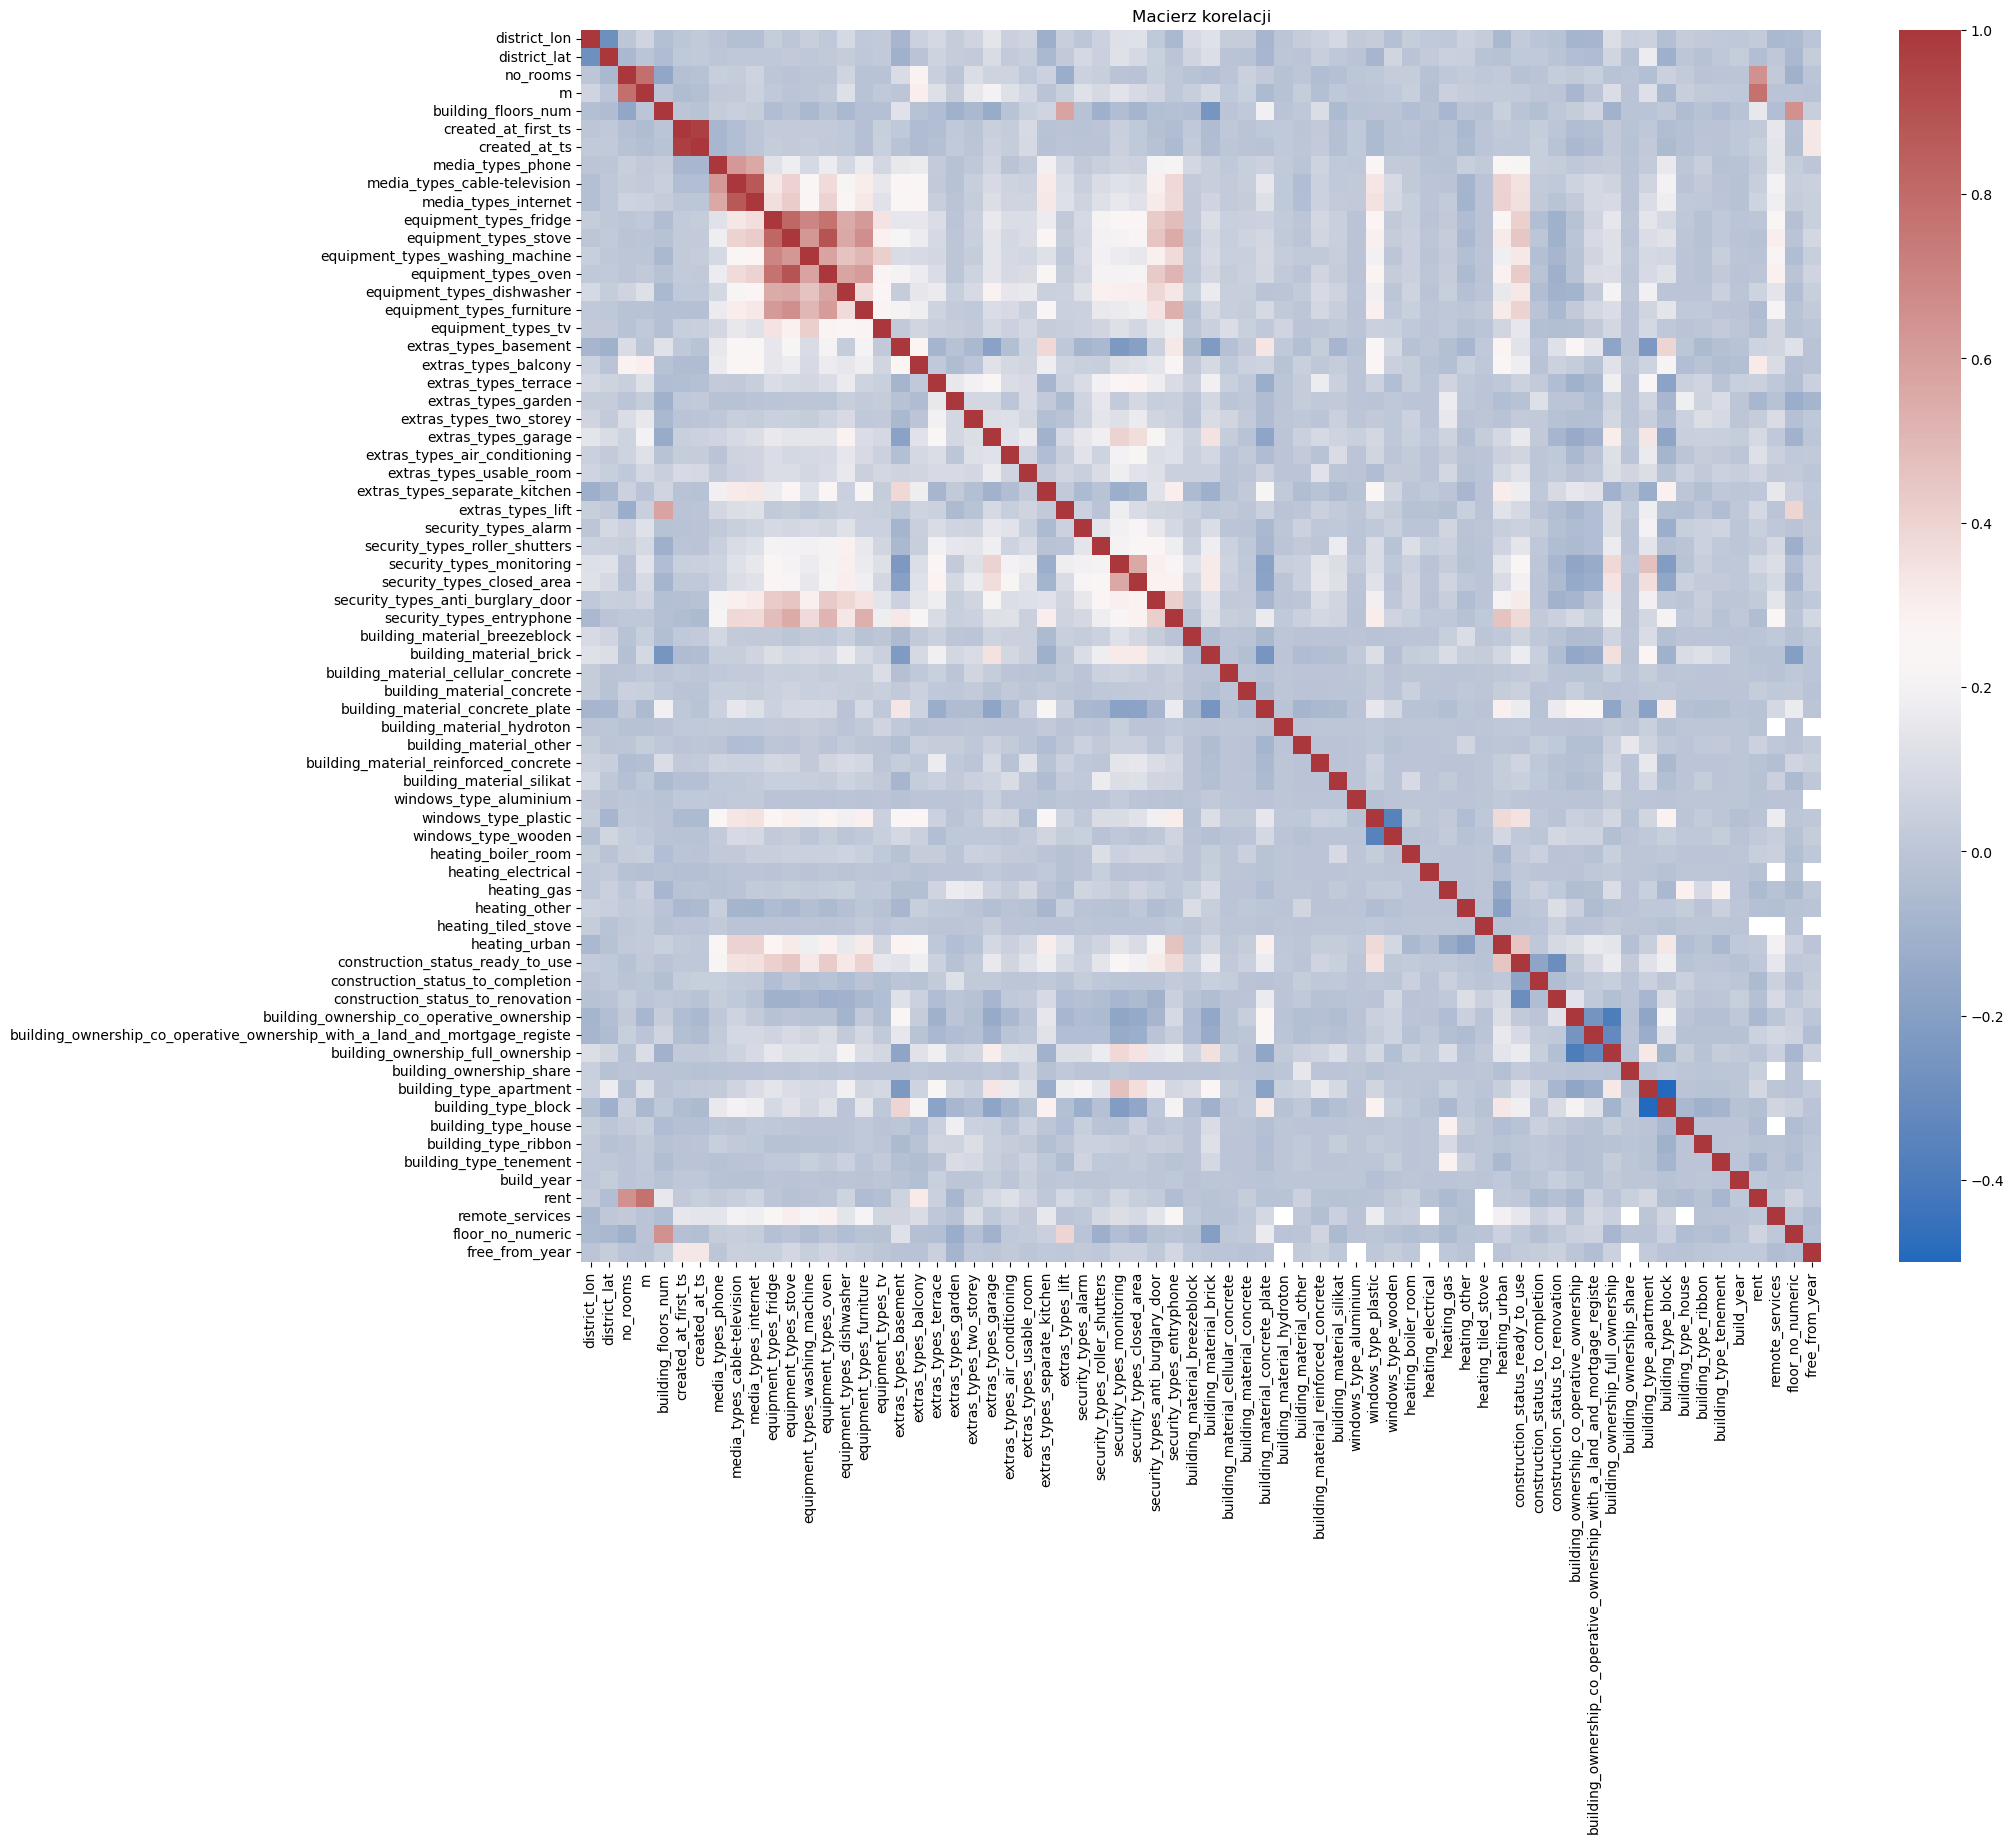

In [20]:
plt.figure(figsize = (20,16))
sns.heatmap(X.corr(), annot=False, cmap='vlag')
plt.title("Macierz korelacji")
plt.show()

In [21]:
c = X.iloc[:,:-1].corr().abs()

#tylko dolna część macierzy
mask = np.triu(np.ones(c.shape), k=1).astype(bool)
s = c.where(mask).unstack()

result = s[np.abs(s) >= 0.7].sort_values(ascending=False)
print(result.to_string())

created_at_ts          created_at_first_ts             0.969027
equipment_types_oven   equipment_types_stove           0.888789
media_types_internet   media_types_cable-television    0.876749
equipment_types_stove  equipment_types_fridge          0.814722
m                      no_rooms                        0.789170
rent                   m                               0.776305
equipment_types_oven   equipment_types_fridge          0.770328


In [22]:
columns_to_drop = ['created_at_ts',
                   'equipment_types_stove',
                   'media_types_internet'] # corr > 0.8

In [23]:
X_dropped = X.drop(columns_to_drop, axis=1)

In [24]:
# Selekcja zmiennych

In [25]:
X_dropped.shape

(5953, 65)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_dropped, y, test_size=0.2, random_state=42)

In [27]:
print(y_test.mean())
print(y_train.mean())

7017.856120906801
7021.039886602268


In [28]:
# Do lepszego podziału stworzymy koszyki do stratyfikacji danych

In [29]:
y.shape

(5953,)

In [30]:
y_binned = pd.qcut(y, q=10, duplicates='drop')

In [31]:
print(y_binned)

0       (5853.66, 6234.38]
1       (5853.66, 6234.38]
2       (525.089, 5384.62]
3       (5384.62, 5853.66]
4       (6560.69, 6903.85]
               ...        
5948     (7272.73, 7700.0]
5949     (8750.0, 20000.0]
5950     (7272.73, 7700.0]
5951     (7272.73, 7700.0]
5952    (6903.85, 7272.73]
Name: price_per_m, Length: 5953, dtype: category
Categories (10, interval[float64, right]): [(525.089, 5384.62] < (5384.62, 5853.66] < (5853.66, 6234.38] < (6234.38, 6560.69] ... (7272.73, 7700.0] < (7700.0, 8116.28] < (8116.28, 8750.0] < (8750.0, 20000.0]]


In [32]:
def find_optimal_bins(X, y, max_bins=10, test_size=0.2, random_state=42):
    best_q = 1
    best_diff = float('inf')
    
    for q in range(2, max_bins + 1):
        y_binned = pd.qcut(y, q=q, duplicates='drop')  # tworzymy koszyki
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y_binned
        )
        # Sprawdzamy różnicę między średnimi
        diff = abs(y_train.mean() - y_test.mean())
        
        # Zapisujemy najlepszą liczbę koszyków, gdzie różnica jest najmniejsza
        if diff < best_diff:
            best_diff = diff
            best_q = q
    
    return best_q

In [33]:
optimal_bins = find_optimal_bins(X_dropped, y, max_bins=20)
print(optimal_bins)

15


In [34]:
y_binned = pd.qcut(y, q=optimal_bins, duplicates='drop')

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
            X_dropped, y, test_size=0.2, random_state=42, stratify=y_binned)

In [36]:
abs(y_train.mean() - y_test.mean())

1.9064393351918625

In [37]:
X_train.dtypes

district_lon           float64
district_lat           float64
no_rooms               float64
m                      float64
building_floors_num    float64
                        ...   
build_year             float64
rent                   float64
remote_services        float64
floor_no_numeric       float64
free_from_year         float64
Length: 65, dtype: object

### Model bazowy

In [49]:
selector = SelectFromModel(DecisionTreeRegressor(), max_features = 30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Przestrzeń przeszukiwania dla hiperparametrów XGBoost
param_grid = {
    'n_estimators': Integer(50, 300),  # Range for integer parameters
    'learning_rate': Real(0.01, 0.3),  # Range for continuous parameters
    'max_depth': Integer(3, 10),
    'subsample': Real(0.5, 1),
    'colsample_bytree': Real(0.5, 1)
}

# Konfiguracja BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=XGBRegressor(random_state=42),
    search_spaces=param_grid,
    n_iter=10,              # Liczba iteracji przeszukiwania
    cv=3,                   # 5-krotna walidacja krzyżowa
    random_state=42,
    n_jobs=-1               # Wykorzystanie wszystkich rdzeni procesora
)

# Dopasowanie BayesSearchCV do danych treningowych z wyselekcjonowanymi cechami
bayes_search.fit(X_train_selected, y_train)

# Pobranie najlepszego modelu i optymalnych hiperparametrów
best = bayes_search.best_estimator_
best_params = bayes_search.best_params_
print("Najlepsze hiperparametry:", best_params)

# Predykcja na zbiorze testowym za pomocą najlepszego modelu
y_pred = best.predict(X_test_selected)

# Obliczenie RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed

Najlepsze hiperparametry: OrderedDict([('colsample_bytree', 0.9061979941786817), ('learning_rate', 0.059842752805002605), ('max_depth', 7), ('n_estimators', 251), ('subsample', 0.7615261640271918)])
RMSE: 720.1589267562922


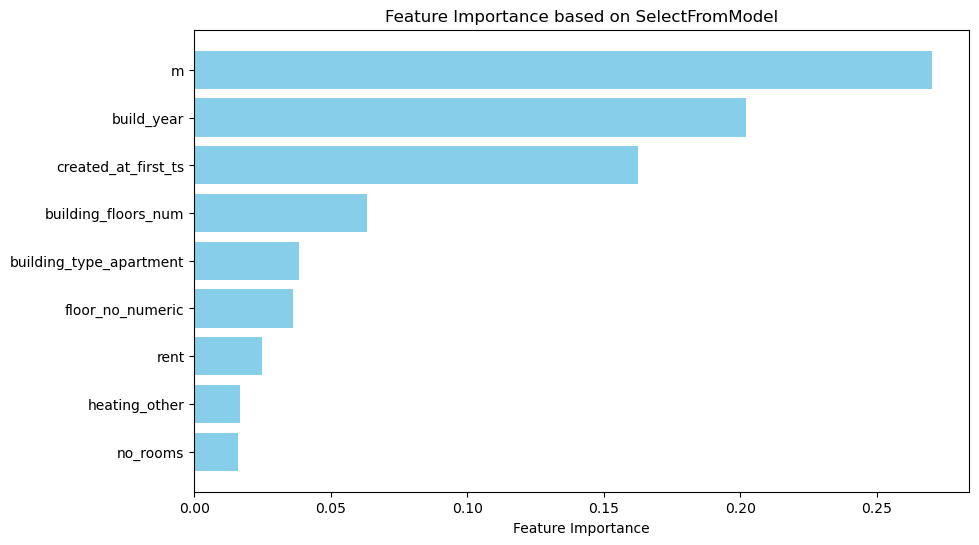

In [50]:
# Pobranie wartości istotności zmiennych
feature_importances = selector.estimator_.feature_importances_
selected_features = selector.get_support()  # maska wybranych cech
selected_feature_names = X_train.columns[selected_features].tolist()

# Sortowanie istotności cech i ich nazw
sorted_idx = np.argsort(feature_importances[selected_features])[::-1]
sorted_importances = feature_importances[selected_features][sorted_idx]
sorted_feature_names = np.array(selected_feature_names)[sorted_idx]

# Wykres istotności
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance based on SelectFromModel")
plt.gca().invert_yaxis()
plt.show()

### Model z cechami opisowymi - TF-IDF

In [40]:
df1 = pd.read_csv("real_estate_not_imputed.csv")

# Przygotowanie danych tekstowych
df1['description'] = df1['description'].fillna('')
df1['title'] = df1['title'].fillna('')
df1['full_text'] = df1['title'] + ' ' + df1['description']

# Przekształcenie tekstu na TF-IDF tylko dla wybranych próbek
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_text_all = tfidf.fit_transform(df1['full_text']).toarray()

In [41]:
df_tfidf = np.hstack([X_dropped, X_text_all])

X_train, X_test, y_train, y_test = train_test_split(
            df_tfidf, y, test_size=0.2, random_state=42, stratify=y_binned)

selector = SelectFromModel(DecisionTreeRegressor(), max_features = 30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Przestrzeń przeszukiwania dla hiperparametrów XGBoost
param_grid = {
    'n_estimators': Integer(50, 300),  # Range for integer parameters
    'learning_rate': Real(0.01, 0.3),  # Range for continuous parameters
    'max_depth': Integer(3, 10),
    'subsample': Real(0.5, 1),
    'colsample_bytree': Real(0.5, 1)
}

# Konfiguracja BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=XGBRegressor(random_state=42),
    search_spaces=param_grid,
    n_iter=10,              # Liczba iteracji przeszukiwania
    cv=3,                   # 5-krotna walidacja krzyżowa
    random_state=42,
    n_jobs=-1               # Wykorzystanie wszystkich rdzeni procesora
)

# Dopasowanie BayesSearchCV do danych treningowych z wyselekcjonowanymi cechami
bayes_search.fit(X_train_selected, y_train)

# Pobranie najlepszego modelu i optymalnych hiperparametrów
best = bayes_search.best_estimator_
best_params = bayes_search.best_params_
print("Najlepsze hiperparametry:", best_params)

# Predykcja na zbiorze testowym za pomocą najlepszego modelu
y_pred = best.predict(X_test_selected)

# Obliczenie RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

Najlepsze hiperparametry: OrderedDict([('colsample_bytree', 0.9061979941786817), ('learning_rate', 0.059842752805002605), ('max_depth', 7), ('n_estimators', 251), ('subsample', 0.7615261640271918)])
RMSE: 675.06690514064


### Model z cechami opisowymi - Bert

In [42]:
df2 = pd.read_csv("real_estate_imputed.csv")

# Wczytanie modelu BERT i tokenizera
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embedding

title_embeddings = np.array([get_bert_embedding(title) for title in df2['title']])
description_embeddings = np.array([get_bert_embedding(description) for description in df2['description']])

In [43]:
textual_embeddings = np.hstack([title_embeddings, description_embeddings])
df_embedded = np.hstack([X_dropped, textual_embeddings])

X_train, X_test, y_train, y_test = train_test_split(
            df_embedded, y, test_size=0.2, random_state=42, stratify=y_binned)

selector = SelectFromModel(DecisionTreeRegressor(), max_features = 30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Przestrzeń przeszukiwania dla hiperparametrów XGBoost
param_grid = {
    'n_estimators': Integer(50, 300),  # Range for integer parameters
    'learning_rate': Real(0.01, 0.3),  # Range for continuous parameters
    'max_depth': Integer(3, 10),
    'subsample': Real(0.5, 1),
    'colsample_bytree': Real(0.5, 1)
}

# Konfiguracja BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=XGBRegressor(random_state=42),
    search_spaces=param_grid,
    n_iter=10,              # Liczba iteracji przeszukiwania
    cv=3,                   # 5-krotna walidacja krzyżowa
    random_state=42,
    n_jobs=-1               # Wykorzystanie wszystkich rdzeni procesora
)

# Dopasowanie BayesSearchCV do danych treningowych z wyselekcjonowanymi cechami
bayes_search.fit(X_train_selected, y_train)

# Pobranie najlepszego modelu i optymalnych hiperparametrów
best = bayes_search.best_estimator_
best_params = bayes_search.best_params_
print("Najlepsze hiperparametry:", best_params)

# Predykcja na zbiorze testowym za pomocą najlepszego modelu
y_pred = best.predict(X_test_selected)

# Obliczenie RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed

Najlepsze hiperparametry: OrderedDict([('colsample_bytree', 0.9061979941786817), ('learning_rate', 0.059842752805002605), ('max_depth', 7), ('n_estimators', 251), ('subsample', 0.7615261640271918)])
RMSE: 750.664953462636


### Model z uwzględnieniem cech geograficznych

In [54]:
df3 = pd.read_csv("real_estate_imputed_geopy.csv")

df_geo = np.hstack([X_dropped, df3[['distance_to_park', 'distance_to_school', 'distance_to_bus_stop', 'distance_to_market', 'distance_to_shopping_center']]])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
            df_geo, y, test_size=0.2, random_state=42, stratify=y_binned)

selector = SelectFromModel(DecisionTreeRegressor(), max_features = 30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Przestrzeń przeszukiwania dla hiperparametrów XGBoost
param_grid = {
    'n_estimators': Integer(50, 300),  # Range for integer parameters
    'learning_rate': Real(0.01, 0.3),  # Range for continuous parameters
    'max_depth': Integer(3, 10),
    'subsample': Real(0.5, 1),
    'colsample_bytree': Real(0.5, 1)
}

# Konfiguracja BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=XGBRegressor(random_state=42),
    search_spaces=param_grid,
    n_iter=10,              # Liczba iteracji przeszukiwania
    cv=3,                   # 5-krotna walidacja krzyżowa
    random_state=42,
    n_jobs=-1               # Wykorzystanie wszystkich rdzeni procesora
)

# Dopasowanie BayesSearchCV do danych treningowych z wyselekcjonowanymi cechami
bayes_search.fit(X_train_selected, y_train)

# Pobranie najlepszego modelu i optymalnych hiperparametrów
best = bayes_search.best_estimator_
best_params = bayes_search.best_params_
print("Najlepsze hiperparametry:", best_params)

# Predykcja na zbiorze testowym za pomocą najlepszego modelu
y_pred = best.predict(X_test_selected)

# Obliczenie RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed

Najlepsze hiperparametry: OrderedDict([('colsample_bytree', 0.9061979941786817), ('learning_rate', 0.059842752805002605), ('max_depth', 7), ('n_estimators', 251), ('subsample', 0.7615261640271918)])
RMSE: 736.0833519551363


### Model finalny

In [57]:
df_final = np.hstack([X_dropped, X_text_all, df3[['distance_to_park', 'distance_to_school', 'distance_to_bus_stop', 'distance_to_market', 'distance_to_shopping_center']]])

X_train, X_test, y_train, y_test = train_test_split(
            df_final, y, test_size=0.2, random_state=42, stratify=y_binned)

selector = SelectFromModel(DecisionTreeRegressor(), max_features = 30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Przestrzeń przeszukiwania dla hiperparametrów XGBoost
param_grid = {
    'n_estimators': Integer(50, 300),  # Range for integer parameters
    'learning_rate': Real(0.01, 0.3),  # Range for continuous parameters
    'max_depth': Integer(3, 10),
    'subsample': Real(0.5, 1),
    'colsample_bytree': Real(0.5, 1)
}

# Konfiguracja BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=XGBRegressor(random_state=42),
    search_spaces=param_grid,
    n_iter=10,              # Liczba iteracji przeszukiwania
    cv=3,                   # 5-krotna walidacja krzyżowa
    random_state=42,
    n_jobs=-1               # Wykorzystanie wszystkich rdzeni procesora
)

# Dopasowanie BayesSearchCV do danych treningowych z wyselekcjonowanymi cechami
bayes_search.fit(X_train_selected, y_train)

# Pobranie najlepszego modelu i optymalnych hiperparametrów
best = bayes_search.best_estimator_
best_params = bayes_search.best_params_
print("Najlepsze hiperparametry:", best_params)

# Predykcja na zbiorze testowym za pomocą najlepszego modelu
y_pred = best.predict(X_test_selected)

# Obliczenie RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed

Najlepsze hiperparametry: OrderedDict([('colsample_bytree', 0.9061979941786817), ('learning_rate', 0.059842752805002605), ('max_depth', 7), ('n_estimators', 251), ('subsample', 0.7615261640271918)])
RMSE: 670.5762286084513
